# Confidence Interval Methods: Exact, CLT, and Bootstrap

This notebook demonstrates different approaches to constructing confidence intervals:

1. **Exact formulas** (when distribution is known)
2. **Central Limit Theorem (CLT) approximation**
3. **Bootstrap methods** (resampling-based)

We'll verify coverage probabilities through simulation and explore when CLT fails.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = '#212121'
plt.rcParams['axes.facecolor'] = '#212121'
np.random.seed(42)

---
## Part 1: Comparing CI Methods for the Mean

### Setup: Normal Distribution (Known Ground Truth)

We'll sample from a Normal distribution with known parameters and compare CI methods.

In [2]:
# Ground truth parameters
TRUE_MEAN = 100
TRUE_STD = 15
SAMPLE_SIZE = 30
CONFIDENCE_LEVEL = 0.95
ALPHA = 1 - CONFIDENCE_LEVEL

# Generate one sample
sample = stats.norm(TRUE_MEAN, TRUE_STD).rvs(SAMPLE_SIZE)
print(f"Sample mean: {np.mean(sample):.2f}")
print(f"Sample std: {np.std(sample, ddof=1):.2f}")
print(f"True mean: {TRUE_MEAN}")

Sample mean: 97.18
Sample std: 13.50
True mean: 100


### Method 1: Exact t-interval (Unknown Variance)

When sampling from a normal distribution with unknown variance, the exact CI uses the t-distribution:

$$\bar{x} \pm t_{\alpha/2, n-1} \cdot \frac{s}{\sqrt{n}}$$

In [3]:
def exact_t_interval(data, confidence=0.95):
    """Exact t-interval for the mean (assumes normality)"""
    n = len(data)
    mean = np.mean(data)
    se = stats.sem(data)  # standard error = s / sqrt(n)
    t_crit = stats.t.ppf((1 + confidence) / 2, df=n-1)
    margin = t_crit * se
    return mean - margin, mean + margin

ci_exact = exact_t_interval(sample)
print(f"Exact t-interval: [{ci_exact[0]:.2f}, {ci_exact[1]:.2f}]")
print(f"Contains true mean ({TRUE_MEAN})? {ci_exact[0] <= TRUE_MEAN <= ci_exact[1]}")

Exact t-interval: [92.14, 102.22]
Contains true mean (100)? True


### Method 2: CLT Approximation (z-interval)

For large samples, CLT justifies using the normal distribution:

$$\bar{x} \pm z_{\alpha/2} \cdot \frac{s}{\sqrt{n}}$$

In [4]:
def clt_z_interval(data, confidence=0.95):
    """CLT-based z-interval for the mean"""
    n = len(data)
    mean = np.mean(data)
    se = np.std(data, ddof=1) / np.sqrt(n)
    z_crit = stats.norm.ppf((1 + confidence) / 2)
    margin = z_crit * se
    return mean - margin, mean + margin

ci_clt = clt_z_interval(sample)
print(f"CLT z-interval: [{ci_clt[0]:.2f}, {ci_clt[1]:.2f}]")
print(f"Contains true mean ({TRUE_MEAN})? {ci_clt[0] <= TRUE_MEAN <= ci_clt[1]}")

CLT z-interval: [92.35, 102.01]
Contains true mean (100)? True


### Method 3: Bootstrap Percentile Interval

No distributional assumptions—resample with replacement and use percentiles.

In [5]:
def bootstrap_percentile_interval(data, statistic=np.mean, n_bootstrap=10000, confidence=0.95):
    """Bootstrap percentile confidence interval"""
    n = len(data)
    boot_stats = np.array([
        statistic(np.random.choice(data, size=n, replace=True))
        for _ in range(n_bootstrap)
    ])
    alpha = 1 - confidence
    lower = np.percentile(boot_stats, 100 * alpha / 2)
    upper = np.percentile(boot_stats, 100 * (1 - alpha / 2))
    return lower, upper, boot_stats

ci_boot_lower, ci_boot_upper, boot_means = bootstrap_percentile_interval(sample)
print(f"Bootstrap interval: [{ci_boot_lower:.2f}, {ci_boot_upper:.2f}]")
print(f"Contains true mean ({TRUE_MEAN})? {ci_boot_lower <= TRUE_MEAN <= ci_boot_upper}")

Bootstrap interval: [92.44, 101.95]
Contains true mean (100)? True


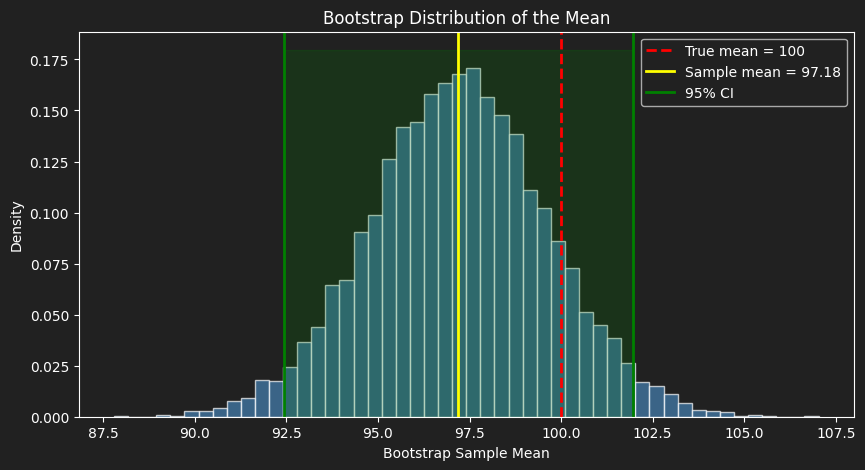

In [6]:
# Visualize bootstrap distribution
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(boot_means, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='white')
ax.axvline(TRUE_MEAN, color='red', linewidth=2, linestyle='--', label=f'True mean = {TRUE_MEAN}')
ax.axvline(np.mean(sample), color='yellow', linewidth=2, label=f'Sample mean = {np.mean(sample):.2f}')
ax.axvline(ci_boot_lower, color='green', linewidth=2, label=f'95% CI')
ax.axvline(ci_boot_upper, color='green', linewidth=2)
ax.fill_betweenx([0, ax.get_ylim()[1]], ci_boot_lower, ci_boot_upper, alpha=0.2, color='green')
ax.set_xlabel('Bootstrap Sample Mean')
ax.set_ylabel('Density')
ax.set_title('Bootstrap Distribution of the Mean')
ax.legend()
plt.show()

### Comparison of All Three Methods

In [7]:
print("="*60)
print("COMPARISON OF CI METHODS")
print("="*60)
print(f"True mean: {TRUE_MEAN}")
print(f"Sample size: {SAMPLE_SIZE}")
print(f"Confidence level: {CONFIDENCE_LEVEL*100}%")
print("-"*60)
print(f"{'Method':<25} {'Lower':<10} {'Upper':<10} {'Width':<10}")
print("-"*60)
print(f"{'Exact t-interval':<25} {ci_exact[0]:<10.2f} {ci_exact[1]:<10.2f} {ci_exact[1]-ci_exact[0]:<10.2f}")
print(f"{'CLT z-interval':<25} {ci_clt[0]:<10.2f} {ci_clt[1]:<10.2f} {ci_clt[1]-ci_clt[0]:<10.2f}")
print(f"{'Bootstrap percentile':<25} {ci_boot_lower:<10.2f} {ci_boot_upper:<10.2f} {ci_boot_upper-ci_boot_lower:<10.2f}")
print("="*60)

COMPARISON OF CI METHODS
True mean: 100
Sample size: 30
Confidence level: 95.0%
------------------------------------------------------------
Method                    Lower      Upper      Width     
------------------------------------------------------------
Exact t-interval          92.14      102.22     10.08     
CLT z-interval            92.35      102.01     9.66      
Bootstrap percentile      92.44      101.95     9.51      


---
## Part 2: Coverage Probability Simulation

If we repeat the experiment many times, a 95% CI should contain the true parameter in ~95% of cases.

Let's verify this by simulation.

In [8]:
def simulate_coverage(n_experiments=1000, sample_size=30, true_mean=100, true_std=15, 
                      confidence=0.95, n_bootstrap=1000):
    """Simulate coverage probabilities for different CI methods"""
    
    coverage = {'exact_t': 0, 'clt_z': 0, 'bootstrap': 0}
    ci_widths = {'exact_t': [], 'clt_z': [], 'bootstrap': []}
    sample_means = []  # Collect all sample means
    
    for _ in range(n_experiments):
        # Generate sample
        sample = stats.norm(true_mean, true_std).rvs(sample_size)
        sample_means.append(np.mean(sample))
        
        # Exact t-interval
        ci = exact_t_interval(sample, confidence)
        if ci[0] <= true_mean <= ci[1]:
            coverage['exact_t'] += 1
        ci_widths['exact_t'].append(ci[1] - ci[0])
        
        # CLT z-interval
        ci = clt_z_interval(sample, confidence)
        if ci[0] <= true_mean <= ci[1]:
            coverage['clt_z'] += 1
        ci_widths['clt_z'].append(ci[1] - ci[0])
        
        # Bootstrap
        ci_lower, ci_upper, _ = bootstrap_percentile_interval(sample, n_bootstrap=n_bootstrap, confidence=confidence)
        if ci_lower <= true_mean <= ci_upper:
            coverage['bootstrap'] += 1
        ci_widths['bootstrap'].append(ci_upper - ci_lower)
    
    # Convert to proportions
    for key in coverage:
        coverage[key] /= n_experiments
    
    return coverage, ci_widths, np.array(sample_means)

print("Running coverage simulation (this may take a minute)...")
coverage, ci_widths, sample_means = simulate_coverage(n_experiments=1000, sample_size=SAMPLE_SIZE)

print("\n" + "="*60)
print("COVERAGE PROBABILITY RESULTS")
print(f"(Expected: {CONFIDENCE_LEVEL*100}%)")
print("="*60)
for method, cov in coverage.items():
    print(f"{method:<20}: {cov*100:.1f}% coverage, avg width = {np.mean(ci_widths[method]):.2f}")

Running coverage simulation (this may take a minute)...

COVERAGE PROBABILITY RESULTS
(Expected: 95.0%)
exact_t             : 94.2% coverage, avg width = 11.06
clt_z               : 93.8% coverage, avg width = 10.60
bootstrap           : 93.2% coverage, avg width = 10.37


### Sampling Distribution of the Mean (CLT Verification)

The Central Limit Theorem states that the sampling distribution of the mean is approximately normal.
Let's visualize this with our 1000 sample means.

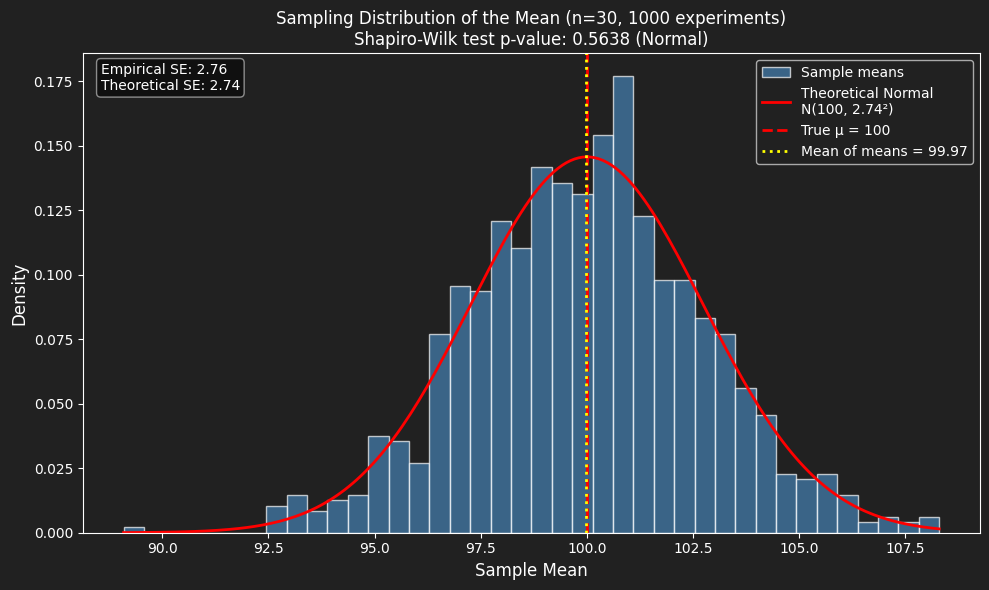


CLT Verification:
  Expected mean of sample means: 100
  Observed mean of sample means: 99.973
  Expected SE (σ/√n): 2.739
  Observed SE: 2.756


In [9]:
# Visualize the sampling distribution of the mean
fig, ax = plt.subplots(figsize=(10, 6))

# Histogram of sample means
ax.hist(sample_means, bins=40, density=True, alpha=0.7, color='steelblue', edgecolor='white', label='Sample means')

# Theoretical normal distribution (by CLT)
theoretical_se = TRUE_STD / np.sqrt(SAMPLE_SIZE)  # σ/√n
x = np.linspace(sample_means.min(), sample_means.max(), 200)
theoretical_pdf = stats.norm(TRUE_MEAN, theoretical_se).pdf(x)
ax.plot(x, theoretical_pdf, 'r-', linewidth=2, label=f'Theoretical Normal\nN({TRUE_MEAN}, {theoretical_se:.2f}²)')

# Add vertical lines
ax.axvline(TRUE_MEAN, color='red', linestyle='--', linewidth=2, label=f'True μ = {TRUE_MEAN}')
ax.axvline(np.mean(sample_means), color='yellow', linestyle=':', linewidth=2, label=f'Mean of means = {np.mean(sample_means):.2f}')

# Test normality (Shapiro-Wilk, using subset for large n)
if len(sample_means) > 5000:
    _, p_value = stats.shapiro(np.random.choice(sample_means, 5000, replace=False))
else:
    _, p_value = stats.shapiro(sample_means)

ax.set_xlabel('Sample Mean', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'Sampling Distribution of the Mean (n={SAMPLE_SIZE}, 1000 experiments)\n'
             f'Shapiro-Wilk test p-value: {p_value:.4f} ({"Normal" if p_value > 0.05 else "Not Normal"})', fontsize=12)
ax.legend(loc='upper right')

# Add statistics text
stats_text = f"Empirical SE: {np.std(sample_means):.2f}\nTheoretical SE: {theoretical_se:.2f}"
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nCLT Verification:")
print(f"  Expected mean of sample means: {TRUE_MEAN}")
print(f"  Observed mean of sample means: {np.mean(sample_means):.3f}")
print(f"  Expected SE (σ/√n): {theoretical_se:.3f}")
print(f"  Observed SE: {np.std(sample_means):.3f}")

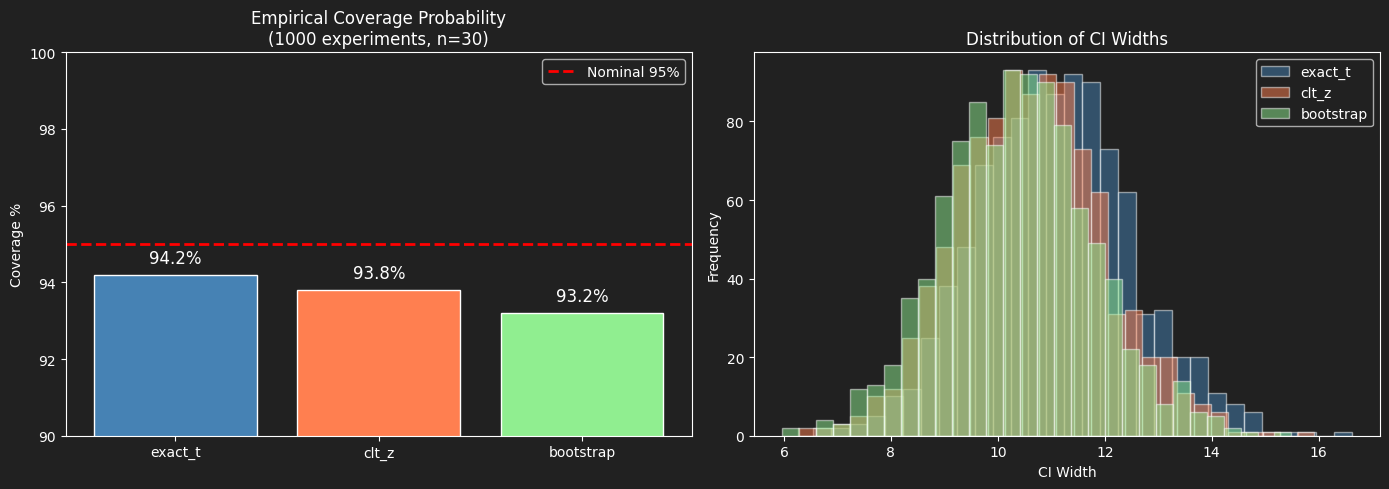

In [10]:
# Visualize coverage
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Coverage bar plot
ax = axes[0]
methods = list(coverage.keys())
coverages = [coverage[m] * 100 for m in methods]
colors = ['steelblue', 'coral', 'lightgreen']
bars = ax.bar(methods, coverages, color=colors, edgecolor='white')
ax.axhline(95, color='red', linestyle='--', linewidth=2, label='Nominal 95%')
ax.set_ylabel('Coverage %')
ax.set_title('Empirical Coverage Probability\n(1000 experiments, n=30)')
ax.set_ylim(90, 100)
ax.legend()
for bar, cov in zip(bars, coverages):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
            f'{cov:.1f}%', ha='center', fontsize=12)

# CI width distribution
ax = axes[1]
for method, color in zip(methods, colors):
    ax.hist(ci_widths[method], bins=30, alpha=0.5, label=method, color=color, edgecolor='white')
ax.set_xlabel('CI Width')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of CI Widths')
ax.legend()

plt.tight_layout()
plt.show()

### Visualizing Individual CIs

Let's visualize 50 CIs and see how many capture the true mean.

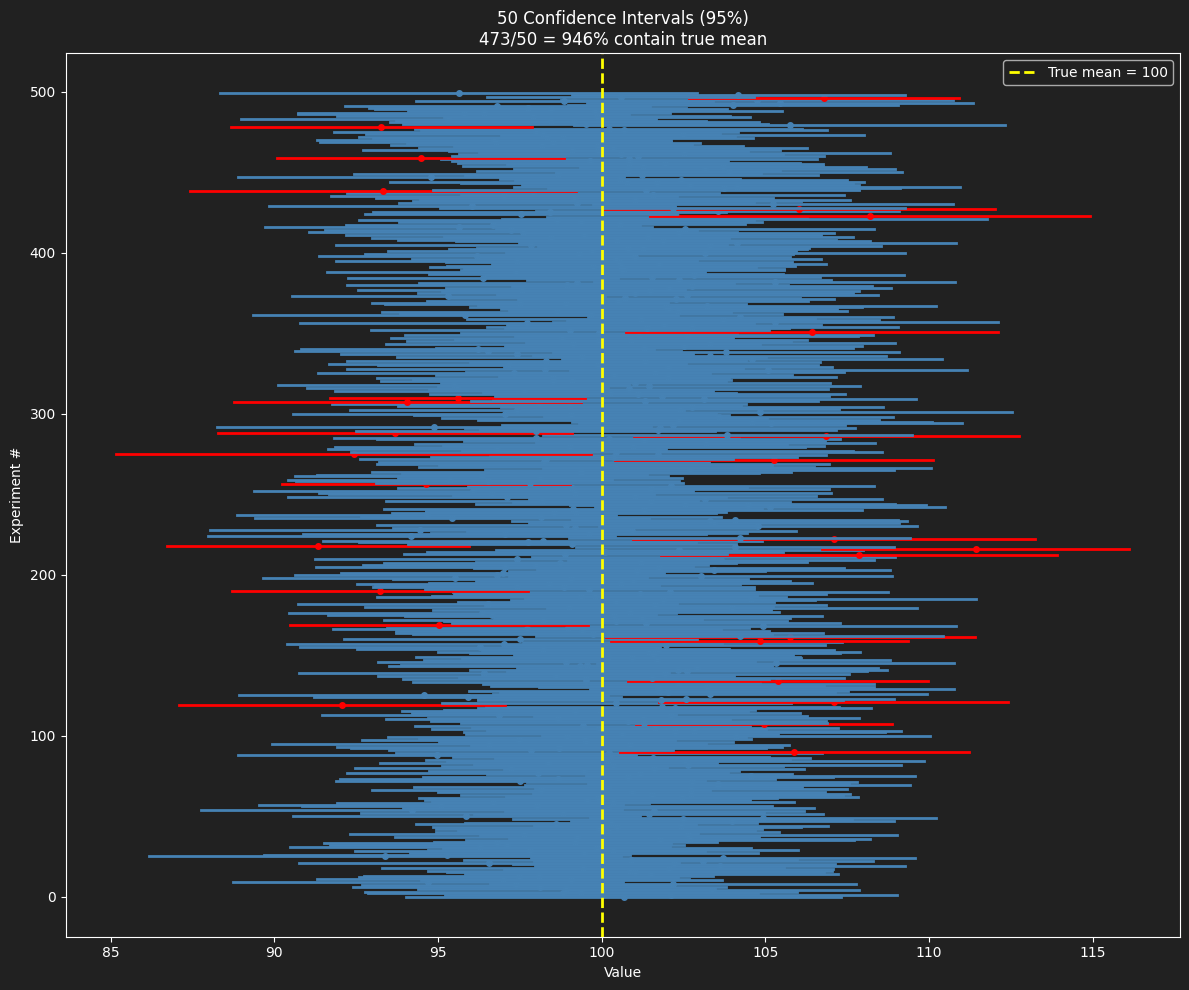

In [11]:
# Generate 50 experiments and plot CIs
n_show = 500
fig, ax = plt.subplots(figsize=(12, 10))

np.random.seed(123)
contains_true = 0

for i in range(n_show):
    sample = stats.norm(TRUE_MEAN, TRUE_STD).rvs(SAMPLE_SIZE)
    ci = exact_t_interval(sample)
    sample_mean = np.mean(sample)
    
    if ci[0] <= TRUE_MEAN <= ci[1]:
        color = 'steelblue'
        contains_true += 1
    else:
        color = 'red'
    
    ax.plot([ci[0], ci[1]], [i, i], color=color, linewidth=2)
    ax.plot(sample_mean, i, 'o', color=color, markersize=4)

ax.axvline(TRUE_MEAN, color='yellow', linewidth=2, linestyle='--', label=f'True mean = {TRUE_MEAN}')
ax.set_xlabel('Value')
ax.set_ylabel('Experiment #')
ax.set_title(f'50 Confidence Intervals (95%)\n{contains_true}/50 = {contains_true/50*100:.0f}% contain true mean')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

---
## Part 3: When CLT Fails - Skewed Distributions

CLT works well for large samples, but can fail for:
- Small samples
- Highly skewed distributions
- Parameters other than the mean

### Example: Estimating the Median of an Exponential Distribution

Exponential distribution (λ = 0.1)
True mean: 10.00
True median: 6.93


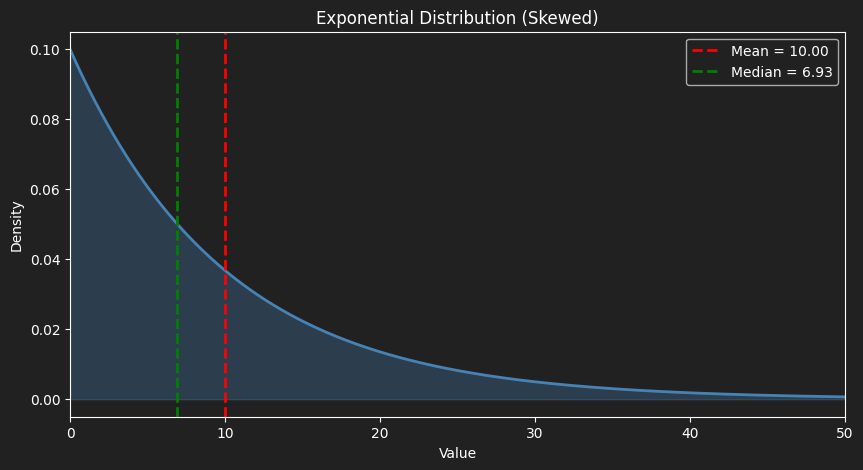

In [32]:
# Exponential distribution - highly skewed
LAMBDA = 1/10  # rate parameter
TRUE_MEDIAN_EXP = np.log(2) / LAMBDA  # = ln(2) * 10 ≈ 6.93
TRUE_MEAN_EXP = 1 / LAMBDA  # = 10
SAMPLE_SIZE = 100
CONFIDENCE_LEVEL = 0.95
ALPHA = 1 - CONFIDENCE_LEVEL

print(f"Exponential distribution (λ = {LAMBDA})")
print(f"True mean: {TRUE_MEAN_EXP:.2f}")
print(f"True median: {TRUE_MEDIAN_EXP:.2f}")

# Visualize
x = np.linspace(0, 50, 500)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, stats.expon(scale=1/LAMBDA).pdf(x), 'steelblue', linewidth=2)
ax.axvline(TRUE_MEAN_EXP, color='red', linewidth=2, linestyle='--', label=f'Mean = {TRUE_MEAN_EXP:.2f}')
ax.axvline(TRUE_MEDIAN_EXP, color='green', linewidth=2, linestyle='--', label=f'Median = {TRUE_MEDIAN_EXP:.2f}')
ax.fill_between(x, stats.expon(scale=1/LAMBDA).pdf(x), alpha=0.3, color='steelblue')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.set_title('Exponential Distribution (Skewed)')
ax.legend()
ax.set_xlim(0, 50)
plt.show()

### Problem 1: CLT-based CI for Extreme Quantiles

There's no simple exact formula for quantile CIs. Let's estimate the **90th percentile** with a very small sample (n=8) to see CLT fail clearly.

In [33]:
def clt_quantile_interval(data, quantile=0.9, confidence=0.95):
    """CLT approximation for quantile CI (naive approach)
    
    This uses a normal approximation which fails for extreme quantiles
    and small samples from skewed distributions.
    """
    n = len(data)
    q_estimate = np.percentile(data, quantile * 100)
    # Naive SE approximation (this is problematic!)
    se = np.std(data, ddof=1) / np.sqrt(n) * 2  # rough scaling
    z_crit = stats.norm.ppf((1 + confidence) / 2)
    margin = z_crit * se
    return q_estimate - margin, q_estimate + margin

# True 90th percentile of exponential
TRUE_Q90_EXP = stats.expon(scale=1/LAMBDA).ppf(0.9)  # ≈ 23.03

# Generate a VERY small sample from exponential  
np.random.seed(42)
sample_exp = stats.expon(scale=1/LAMBDA).rvs(SAMPLE_SIZE)

print(f"Sample size: {SAMPLE_SIZE}")
print(f"Sample 90th percentile: {np.percentile(sample_exp, 90):.2f}")
print(f"True 90th percentile: {TRUE_Q90_EXP:.2f}")

# CLT approximation
ci_clt_q90 = clt_quantile_interval(sample_exp, quantile=0.9, confidence=CONFIDENCE_LEVEL)
print(f"\nCLT CI for 90th percentile: [{ci_clt_q90[0]:.2f}, {ci_clt_q90[1]:.2f}]")

# Bootstrap
def q90(x):
    return np.percentile(x, 90)

ci_boot_q90_lower, ci_boot_q90_upper, boot_q90s = bootstrap_percentile_interval(
    sample_exp, statistic=q90, n_bootstrap=10000
)
print(f"Bootstrap CI for 90th percentile: [{ci_boot_q90_lower:.2f}, {ci_boot_q90_upper:.2f}]")

Sample size: 100
Sample 90th percentile: 21.89
True 90th percentile: 23.03

CLT CI for 90th percentile: [18.29, 25.50]
Bootstrap CI for 90th percentile: [16.24, 29.74]


### Coverage Simulation: 90th Percentile of Skewed Distribution (n=8)

With extreme quantiles and tiny samples, CLT fails dramatically.

In [34]:
def simulate_quantile_coverage(n_experiments=500, sample_size=8, true_q90=TRUE_Q90_EXP,
                                rate=LAMBDA, confidence=0.95, n_bootstrap=1000):
    """Simulate coverage for 90th percentile estimation from exponential"""
    
    coverage = {'clt': 0, 'bootstrap': 0}
    
    for _ in range(n_experiments):
        sample = stats.expon(scale=1/rate).rvs(sample_size)
        
        # CLT approximation
        ci = clt_quantile_interval(sample, quantile=0.9, confidence=confidence)
        if ci[0] <= true_q90 <= ci[1]:
            coverage['clt'] += 1
        
        # Bootstrap
        ci_lower, ci_upper, _ = bootstrap_percentile_interval(
            sample, statistic=q90, n_bootstrap=n_bootstrap, confidence=confidence
        )
        if ci_lower <= true_q90 <= ci_upper:
            coverage['bootstrap'] += 1
    
    for key in coverage:
        coverage[key] /= n_experiments
    
    return coverage

print(f"Simulating coverage for 90th PERCENTILE of exponential (n={SAMPLE_SIZE})...")
coverage_q90 = simulate_quantile_coverage(n_experiments=500, sample_size=SAMPLE_SIZE)

print("\n" + "="*60)
print(f"COVERAGE FOR 90th PERCENTILE (Exponential, n={SAMPLE_SIZE})")
print(f"Expected: {CONFIDENCE_LEVEL*100:.0f}%")
print("="*60)
print(f"CLT approximation: {coverage_q90['clt']*100:.1f}%")
print(f"Bootstrap: {coverage_q90['bootstrap']*100:.1f}%")

Simulating coverage for 90th PERCENTILE of exponential (n=100)...

COVERAGE FOR 90th PERCENTILE (Exponential, n=100)
Expected: 95%
CLT approximation: 79.4%
Bootstrap: 93.6%


### Problem 2: Mean vs Median as Estimator for Skewed Data

When data are skewed, the **mean** is not robust—it's heavily influenced by extreme values.
The **median** is more robust but has no simple exact CI.

In [15]:
# Simulate data with outliers (contaminated exponential)
np.random.seed(42)
n = 30
clean_data = stats.expon(scale=10).rvs(n)

# Add outliers (contamination)
contaminated_data = clean_data.copy()
outlier_indices = [5, 15, 25]
contaminated_data[outlier_indices] = [100, 150, 200]  # extreme outliers

print("Clean data:")
print(f"  Mean: {np.mean(clean_data):.2f}")
print(f"  Median: {np.median(clean_data):.2f}")
print(f"\nContaminated data (3 outliers):")
print(f"  Mean: {np.mean(contaminated_data):.2f}")
print(f"  Median: {np.median(contaminated_data):.2f}")
print(f"\n→ Mean is heavily affected by outliers!")
print(f"→ Median remains robust.")

Clean data:
  Mean: 8.06
  Median: 5.17

Contaminated data (3 outliers):
  Mean: 22.42
  Median: 6.65

→ Mean is heavily affected by outliers!
→ Median remains robust.


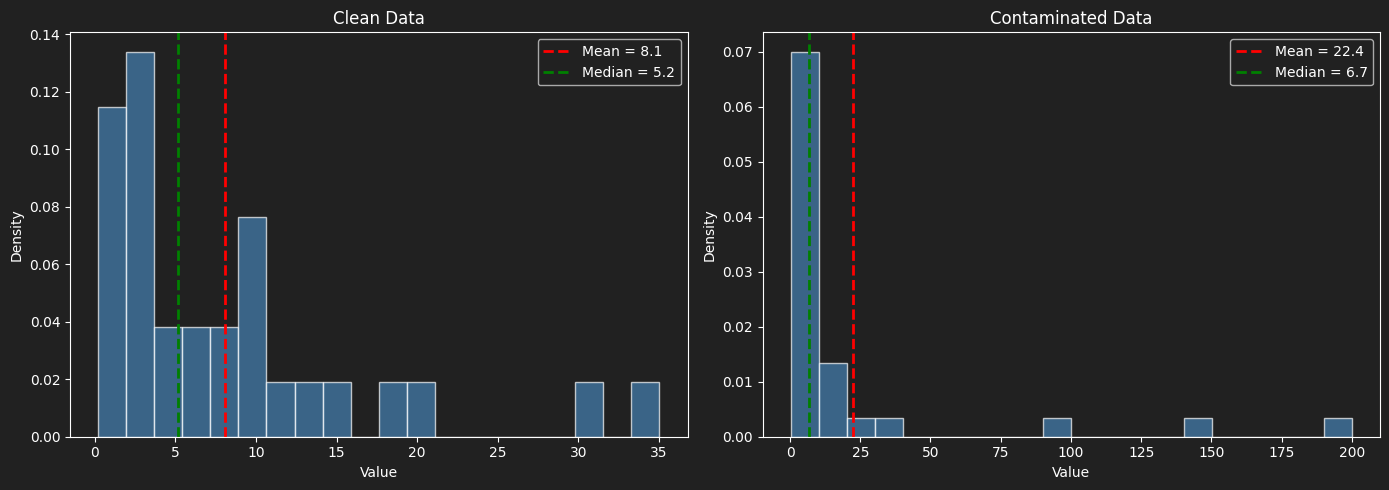

In [16]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, data, title in zip(axes, [clean_data, contaminated_data], ['Clean Data', 'Contaminated Data']):
    ax.hist(data, bins=20, density=True, alpha=0.7, color='steelblue', edgecolor='white')
    ax.axvline(np.mean(data), color='red', linewidth=2, linestyle='--', label=f'Mean = {np.mean(data):.1f}')
    ax.axvline(np.median(data), color='green', linewidth=2, linestyle='--', label=f'Median = {np.median(data):.1f}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.set_title(title)
    ax.legend()

plt.tight_layout()
plt.show()

### Robust Estimators: Trimmed Mean and Winsorized Mean

In [17]:
from scipy.stats import trim_mean

def winsorized_mean(data, proportion=0.1):
    """Winsorized mean: replace extreme values instead of removing"""
    sorted_data = np.sort(data)
    n = len(data)
    k = int(n * proportion)
    winsorized = sorted_data.copy()
    winsorized[:k] = sorted_data[k]
    winsorized[-k:] = sorted_data[-k-1]
    return np.mean(winsorized)

print("Robust Location Estimators (Contaminated Data):")
print("="*50)
print(f"{'Estimator':<25} {'Value':<10}")
print("-"*50)
print(f"{'Mean':<25} {np.mean(contaminated_data):<10.2f}")
print(f"{'Median':<25} {np.median(contaminated_data):<10.2f}")
print(f"{'10% Trimmed Mean':<25} {trim_mean(contaminated_data, 0.1):<10.2f}")
print(f"{'10% Winsorized Mean':<25} {winsorized_mean(contaminated_data, 0.1):<10.2f}")
print("="*50)
print(f"\nTrue center (clean data mean): {np.mean(clean_data):.2f}")

Robust Location Estimators (Contaminated Data):
Estimator                 Value     
--------------------------------------------------
Mean                      22.42     
Median                    6.65      
10% Trimmed Mean          9.22      
10% Winsorized Mean       11.03     

True center (clean data mean): 8.06


### Bootstrap CI for Robust Estimators

In [18]:
# Bootstrap CIs for different estimators
estimators = {
    'Mean': np.mean,
    'Median': np.median,
    '10% Trimmed Mean': lambda x: trim_mean(x, 0.1),
    '10% Winsorized Mean': lambda x: winsorized_mean(x, 0.1)
}

print("Bootstrap 95% CIs for Contaminated Data:")
print("="*60)
print(f"{'Estimator':<25} {'Estimate':<10} {'95% CI':<20}")
print("-"*60)

for name, func in estimators.items():
    estimate = func(contaminated_data)
    ci_lower, ci_upper, _ = bootstrap_percentile_interval(contaminated_data, statistic=func)
    print(f"{name:<25} {estimate:<10.2f} [{ci_lower:.2f}, {ci_upper:.2f}]")

print("="*60)

Bootstrap 95% CIs for Contaminated Data:
Estimator                 Estimate   95% CI              
------------------------------------------------------------
Mean                      22.42      [8.67, 40.91]
Median                    6.65       [3.54, 9.33]
10% Trimmed Mean          9.22       [5.26, 27.17]
10% Winsorized Mean       11.03      [5.71, 38.00]


---
## Summary

### Key Takeaways:

1. **Exact formulas** (t-interval) work when:
   - Data are normally distributed (or n is large enough)
   - Estimating standard parameters (mean)

2. **CLT approximation** works when:
   - Sample size is "large enough" (n ≥ 30 often cited, but depends on skewness)
   - Distribution is not extremely skewed

3. **Bootstrap** is most flexible:
   - Works for any statistic
   - No distributional assumptions
   - Valid for complex estimators (median, trimmed means, etc.)

4. **Robust estimators** (median, trimmed mean) should be used when:
   - Data contain outliers
   - Distribution is skewed
   - Mean is not representative of "typical" value

### When to use what:

| Scenario | Recommended Method |
|----------|-------------------|
| Normal data, estimating mean | Exact t-interval |
| Large n, any distribution | CLT z-interval |
| Small n, skewed data | Bootstrap |
| Any statistic (median, variance, etc.) | Bootstrap |
| Data with outliers | Robust estimator + Bootstrap |